In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import trimesh

scene = trimesh.Scene()

In [2]:
import my_code.diffusion_training.data_loading as data_loading

train_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'train', 64, canonicalize_fmap=None
    )[1]
train_dataset_128 = data_loading.get_val_dataset(
    'FAUST_orig', 'train', 128, canonicalize_fmap=None
    )[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Loading base dataset: 100%|██████████████████████████████████████████████████████████████████████████████| 80/80 [00:38<00:00,  2.08it/s]


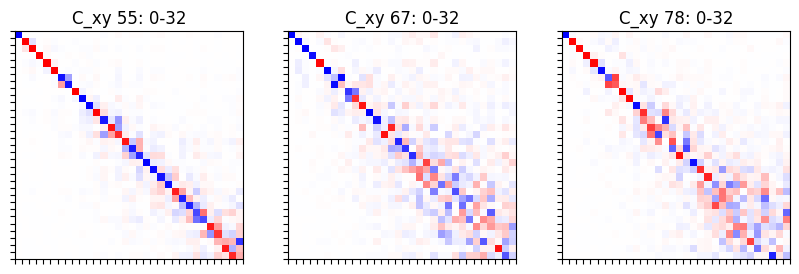

In [11]:
import my_code.utils.plotting_utils as plotting_utils

l = 0
h = 32

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

plotting_utils.plot_Cxy(fig, axs[0], train_dataset[4]['second']['C_gt_xy'][0],
                        'C_xy 55', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], train_dataset[67]['second']['C_gt_xy'][0],
                        'C_xy 67', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], train_dataset[78]['second']['C_gt_xy'][0],
                        'C_xy 78', l, h, show_grid=False, show_colorbar=False)



plt.show()

In [4]:
def flip_random_signs(
    C_xy, idx_start, idx_end, n_signs, row_wise
):
    C_xy = C_xy.clone()
    
    # randomly sample n non-repeating indices between idx_start and idx_end
    idx = np.random.choice(
        np.arange(idx_start, idx_end), n_signs, replace=False
    )
    idx = torch.tensor(idx)
    
    # print(idx)
    
    if row_wise:
        C_xy[idx] = -C_xy[idx]
    else:
        C_xy[:, idx] = -C_xy[:, idx]

    return C_xy

In [ ]:
data_10 = train_dataset[2]

C_gt_xy = data_10['second']['C_gt_xy'][0]

# sign_flip = torch.ones(C_gt_xy.shape[0], dtype=torch.float32)
# sign_flip[[16, 18, 20]] = -1
# sign_flip = sign_flip.unsqueeze(1)
# C_xy_err = C_gt_xy * sign_flip

C_xy_err = flip_random_signs(
    C_gt_xy,
    idx_start=20,
    idx_end=30,
    n_signs=4,
    row_wise=True
)
    

l = 0
h = 64

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

plotting_utils.plot_Cxy(fig, axs[0], C_gt_xy,
                        'C_xy gt', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], C_xy_err,
                        'C_xy err', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], C_gt_xy - C_xy_err,
                        'diff', l, h, show_grid=False, show_colorbar=False)


plt.show()

In [6]:
import my_code.diffusion_training.evaluate_samples as evaluate_samples

geo_err_gt, geo_err_est, p2p_gt, p2p_est = evaluate_samples.compare_fmap_with_gt(
    Cxy_est=C_xy_err.unsqueeze(0),
    data_x=data_10['first'],
    data_y=data_10['second']
)

print('geo_err_gt', geo_err_gt.sum())
print('geo_err_est', geo_err_est.sum())

geo_err_gt tensor(52.4204)
geo_err_est tensor(107.3663)


In [16]:
from tqdm import tqdm

mean_factor_increase_list = []
median_factor_increase_list = []
max_factor_increase_list = []
min_factor_increase_list = []

n_sign_flips_list = [1, 2, 4, 8]
for n_signs in n_sign_flips_list:
    factor_increase_list = torch.tensor([])    
    
    iterator = tqdm(range(1000))
    for _ in iterator:
        
        # select a random shape
        rand_idx = np.random.randint(1, len(train_dataset))
        data_10 = train_dataset[rand_idx]
        
        # get the ground truth C_xy
        C_gt_xy = data_10['second']['C_gt_xy'][0]
        
        # randomly flip the signs
        C_xy_err = flip_random_signs(
            C_gt_xy,
            idx_start=0,
            idx_end=64,
            n_signs=n_signs,
            row_wise=True
        )
        # calculate the geodesic error
        geo_err_gt, geo_err_est, p2p_gt, p2p_est = evaluate_samples.compare_fmap_with_gt(
            Cxy_est=C_xy_err.unsqueeze(0),
            data_x=data_10['first'],
            data_y=data_10['second']
        )
        factor_increase = geo_err_est.sum() / geo_err_gt.sum()
        factor_increase_list = torch.cat([factor_increase_list, factor_increase.unsqueeze(0)])
        
        if factor_increase > 3:
            iterator.set_description(f'factor_increase {factor_increase},shape {rand_idx}')

    mean_factor_increase_list.append(factor_increase_list.mean())
    median_factor_increase_list.append(factor_increase_list.median())
    max_factor_increase_list.append(factor_increase_list.max())
    min_factor_increase_list.append(factor_increase_list.min())
    
    print(f'{n_signs} signs:')
    print('mean', factor_increase_list.mean())
    print('median', factor_increase_list.median())
    print('max', factor_increase_list.max())
    print('min', factor_increase_list.min())
    print()
    

# plt.plot(
#     mean_factor_increase_list, label='mean')
# plt.plot(median_factor_increase_list, label='median')

# plot the factors, x axis is the number of signs flipped
plt.plot(n_sign_flips_list, mean_factor_increase_list, '.-', label='mean')
plt.plot(n_sign_flips_list, median_factor_increase_list, '.-', label='median')

plt.title('Factor increase in geodesic error')
plt.xlabel('Number of signs flipped')
plt.ylabel('Factor increase')
plt.legend()
plt.show()

 46%|████████████████████████████████████████████▏                                                    | 456/1000 [03:50<14:57,  1.65s/it]

: 

: 

: 

## Find failed cases

In [10]:
from tqdm import tqdm

mean_factor_increase_list = []
median_factor_increase_list = []
max_factor_increase_list = []
min_factor_increase_list = []


for n_signs in [1, 2, 4, 8]:
    factor_increase_list = torch.tensor([])    
    
    for _ in tqdm(range(1000)):
        
        # select a random shape
        rand_idx = np.random.randint(1, len(train_dataset))
        data_10 = train_dataset[rand_idx]
        
        # get the ground truth C_xy
        C_gt_xy = data_10['second']['C_gt_xy'][0]
        
        # randomly flip the signs
        C_xy_err = flip_random_signs(
            C_gt_xy,
            idx_start=0,
            idx_end=64,
            n_signs=n_signs,
            row_wise=True
        )
        # calculate the geodesic error
        geo_err_gt, geo_err_est, p2p_gt, p2p_est = evaluate_samples.compare_fmap_with_gt(
            Cxy_est=C_xy_err.unsqueeze(0),
            data_x=data_10['first'],
            data_y=data_10['second']
        )
        
        factor_increase = geo_err_est.sum() / geo_err_gt.sum()
        
        if factor_increase > 2:
            raise ValueError(f'factor_increase {factor_increase:.2f}, shape {rand_idx}')

 20%|███████████████████▎                                                                             | 199/1000 [00:34<02:17,  5.83it/s]


ValueError: factor_increase 2.13, shape 4

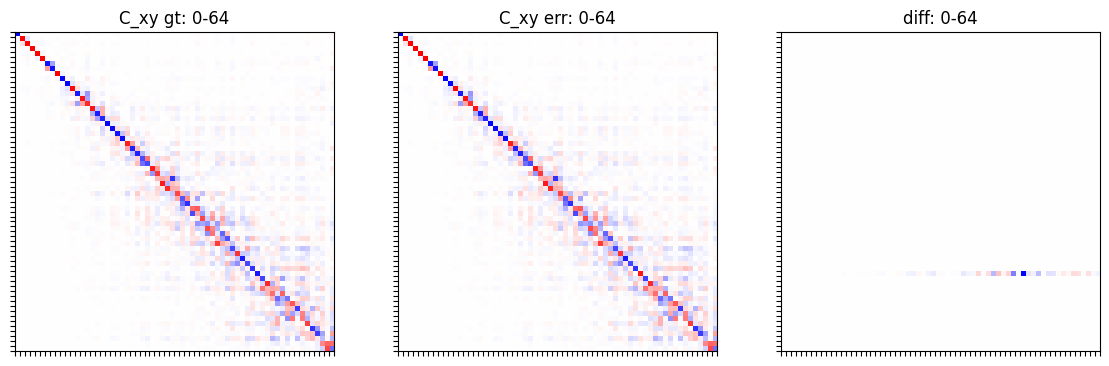

In [12]:
l = 0
h = 64

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

plotting_utils.plot_Cxy(fig, axs[0], C_gt_xy,
                        'C_xy gt', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], C_xy_err,
                        'C_xy err', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], C_gt_xy - C_xy_err,
                        'diff', l, h, show_grid=False, show_colorbar=False)


plt.show()

In [15]:
import my_code.diffusion_training.evaluate_samples as evaluate_samples

geo_err_gt, geo_err_est, p2p_gt, p2p_est = evaluate_samples.compare_fmap_with_gt(
    Cxy_est=C_xy_err.unsqueeze(0),
    data_x=data_10['first'],
    data_y=data_10['second']
)

print('geo_err_gt', geo_err_gt.sum())
print('geo_err_est', geo_err_est.sum())

geo_err_gt tensor(29.0436)
geo_err_est tensor(61.9948)


## Zoomout refinement

In [ ]:
from pyFM_fork.pyFM.refine.zoomout import zoomout_refine

data_10 = train_dataset[12]

C_gt_xy = data_10['second']['C_gt_xy'][0][:64, :64]

C_xy_err = flip_random_signs(
    C_gt_xy,
    idx_start=0,
    idx_end=30,
    n_signs=4,
    row_wise=True
)
Cxy_refined = zoomout_refine(
    FM_12=C_xy_err[:48, :48].numpy(), 
    evects1=data_10['first']['evecs'].numpy(), 
    evects2=data_10['second']['evecs'].numpy(),
    nit=16, step=1,
    verbose=True
)

l = 0
h = 32

fig, axs = plt.subplots(1, 3, figsize=(14, 5))

plotting_utils.plot_Cxy(fig, axs[0], C_gt_xy,
                        'C_xy gt', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], C_gt_xy - C_xy_err,
                        'C_xy err', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], C_gt_xy - Cxy_refined,
                        'diff', l, h, show_grid=False, show_colorbar=False)
plt.show()

In [ ]:
Cxy_refined = torch.tensor(Cxy_refined)

geo_err_gt, geo_err_ref, _, _ = evaluate_samples.compare_fmap_with_gt(
    Cxy_est=Cxy_refined.unsqueeze(0),
    data_x=data_10['first'],
    data_y=data_10['second']
)
geo_err_gt, geo_err_err, _, _ = evaluate_samples.compare_fmap_with_gt(
    Cxy_est=C_xy_err.unsqueeze(0),
    data_x=data_10['first'],
    data_y=data_10['second']
)

print('geo_err_gt', geo_err_gt.sum())
print('geo_err_err', geo_err_err.sum())
print('geo_err_ref', geo_err_ref.sum())

